In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.insert(0, '/content/drive/My Drive/VAE/')
sys.path.append('/content/drive/My Drive/VAE')
sys.path.append('/content/drive/Cancer-Detection/data/train/benign/')

In [0]:
! git clone --recursive https://github.com/shreyavarshini/Cancer-Detection.git

Cloning into 'Cancer-Detection'...
remote: Enumerating objects: 18689, done.
remote: Total 18689 (delta 0), reused 0 (delta 0), pack-reused 18689
Receiving objects: 100% (18689/18689), 318.63 MiB | 39.24 MiB/s, done.
Checking out files: 100% (18677/18677), done.


In [0]:
# imports and initializations
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms, transforms, utils
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [0]:
! cd '/content/Cancer-Detection/data/train/benign/'

In [0]:
# Arguments for the model
class Args:
  batch_size = 20
  epochs = 10
  no_cuda = False
  seed = 1
  log_interval = 10
  lr = 1e-3

args=Args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda else "cpu")

In [0]:
# Dataset loader
def load_dataset( folder ):
    data_path = '/content/Cancer-Detection/data/' + folder
    transform = transforms.Compose([
    transforms.Resize(( 128, 128 ) ),
    transforms.ToTensor()
    ])
    dataset = datasets.ImageFolder( root=data_path, transform=transform )

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=20,
        num_workers=3,
        shuffle=True
    )
    return loader

train_loader = load_dataset( 'train' )
test_loader = load_dataset( 'test' )

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        '''
        Args:
            input_dim: A integer indicating the size of input
            hidden_dim: A integer indicating the size of hidden dimension
            z_dim: A integer indicating the latent dimension
        '''
        super().__init__()

        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]
        z_mu = self.mu(hidden)
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(hidden)
        # z_var is of shape [batch_size, latent_dim]

        return z_mu, z_var

In [0]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        '''
        Args:
            z_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the output dimension
        '''
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        predicted = torch.sigmoid(self.out(hidden))
        # predicted is of shape [batch_size, output_dim]
        return predicted


In [0]:
class VAE(nn.Module):
    def __init__(self, enc, dec):
        ''' This the VAE, which takes a encoder and decoder.
        '''
        super().__init__()

        self.encode = enc
        self.decode = dec

    def forward(self, x):
        # encode
        z_mu, z_var = self.encode(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.decode(x_sample)
        return predicted, z_mu, z_var

In [0]:
INPUT_DIM = 49152
HIDDEN_DIM = 400
LATENT_DIM = 50

# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

# vae
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr)

Train Epoch: 1 [0/12775 (0%)]	Loss: 34446.040625
Train Epoch: 1 [200/12775 (2%)]	Loss: 33859.806250
Train Epoch: 1 [400/12775 (3%)]	Loss: 31693.137500
Train Epoch: 1 [600/12775 (5%)]	Loss: 30747.237500
Train Epoch: 1 [800/12775 (6%)]	Loss: 31055.387500
Train Epoch: 1 [1000/12775 (8%)]	Loss: 29031.612500
Train Epoch: 1 [1200/12775 (9%)]	Loss: 29313.381250
Train Epoch: 1 [1400/12775 (11%)]	Loss: 29872.384375
Train Epoch: 1 [1600/12775 (13%)]	Loss: 28680.246875
Train Epoch: 1 [1800/12775 (14%)]	Loss: 29120.087500
Train Epoch: 1 [2000/12775 (16%)]	Loss: 28872.481250
Train Epoch: 1 [2200/12775 (17%)]	Loss: 28611.956250
Train Epoch: 1 [2400/12775 (19%)]	Loss: 28834.859375
Train Epoch: 1 [2600/12775 (20%)]	Loss: 28342.381250
Train Epoch: 1 [2800/12775 (22%)]	Loss: 27675.993750
Train Epoch: 1 [3000/12775 (23%)]	Loss: 27702.850000
Train Epoch: 1 [3200/12775 (25%)]	Loss: 27206.903125
Train Epoch: 1 [3400/12775 (27%)]	Loss: 28002.878125
Train Epoch: 1 [3600/12775 (28%)]	Loss: 27640.468750
Train E

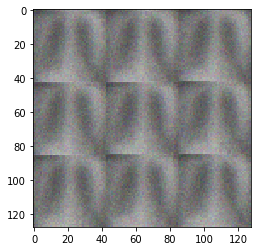

Train Epoch: 2 [0/12775 (0%)]	Loss: 26179.537500
Train Epoch: 2 [200/12775 (2%)]	Loss: 26918.696875
Train Epoch: 2 [400/12775 (3%)]	Loss: 26170.646875
Train Epoch: 2 [600/12775 (5%)]	Loss: 26069.950000
Train Epoch: 2 [800/12775 (6%)]	Loss: 26406.103125
Train Epoch: 2 [1000/12775 (8%)]	Loss: 26604.890625
Train Epoch: 2 [1200/12775 (9%)]	Loss: 26301.200000
Train Epoch: 2 [1400/12775 (11%)]	Loss: 26456.493750


KeyboardInterrupt: ignored

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    # reconstruction loss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 49152), reduction='sum')
    # kl divergence loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 3 * 128 * 128)
        data = data.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        recon_batch, mu, logvar = model(data)

        # reconstruction loss + kl divergence loss
        loss = loss_function(recon_batch, data, mu, logvar)
        
         # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.view(-1, 3 * 128 * 128)
            data = data.to(device)

            # forward pass
            recon_batch, mu, logvar = model(data)

            # total loss
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(1, LATENT_DIM).to(device)
            sample = model.decode(sample).cpu()
            img = sample.view( 128, 128, 3 ).data
            plt.figure()
            plt.imshow(img )
            plt.show()